**Data Source & Course Notice (IBM Skills Network / Coursera)** This notebook was developed as part of a Coursera final project. Datasets and starter materials are publicly accessible via IBM Skills Network and used for educational purposes. All analysis and code are my own; no autograder or proprietary Coursera content is included.

**Building a Rainfall Prediction Classifier**

In [3]:
## Install and import the required libraries
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [5]:
## Load the data
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df.head()
df.count()

,0
Date,145460
Location,145460
MinTemp,143975
MaxTemp,144199
Rainfall,142199
Evaporation,82670
Sunshine,75625
WindGustDir,135134
WindGustSpeed,135197
WindDir9am,134894


In [6]:
### Drop all rows with missing values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

In [7]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [8]:
## Data leakage considerations
df = df.rename(columns={'RainToday': 'RainYesterday',
                        'RainTomorrow': 'RainToday'
                        })

In [9]:
## Location selection
df = df[df.Location.isin(['Melbourne','MelbourneAirport','Watsonia',])]
df. info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

In [10]:
### Create a function to map dates to seasons
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif (month == 3) or (month == 4) or (month == 5):
        return 'Autumn'
    elif (month == 6) or (month == 7) or (month == 8):
        return 'Winter'
    elif (month == 9) or (month == 10) or (month == 11):
        return 'Spring'

In [11]:
## Map the dates to seasons and drop the Date column
df['Date'] = pd.to_datetime(df['Date'])

df['Season'] = df['Date'].apply(date_to_season)

df = df.drop(columns='Date')

df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday,Season
64191,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,W,SW,...,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,No,Yes,Summer
64192,MelbourneAirport,7.8,17.8,1.2,7.2,12.9,SSE,56.0,SW,SSE,...,43.0,1018.0,1019.3,6.0,7.0,12.5,15.8,Yes,No,Summer
64193,MelbourneAirport,6.3,21.1,0.0,6.2,10.5,SSE,31.0,E,S,...,35.0,1020.8,1017.6,1.0,7.0,13.4,19.6,No,No,Summer
64194,MelbourneAirport,8.1,29.2,0.0,6.4,12.5,SSE,35.0,NE,SSE,...,23.0,1016.2,1012.8,5.0,4.0,16.0,28.2,No,No,Summer
64195,MelbourneAirport,9.7,29.0,0.0,7.4,12.3,SE,33.0,SW,SSE,...,31.0,1011.9,1010.3,6.0,2.0,19.4,27.1,No,No,Summer


In [12]:
## Define the feature and target dataframes
X = df.drop(columns='RainToday', axis=1)
y = df['RainToday']

In [13]:
## How balanced are the classes?
y.value_counts()

,count
RainToday,
No,5766
Yes,1791


In [14]:
## Split data into training and test sets, ensuring target stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
## Automatically detect numerical and categorical columns and assign them to separate numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode the categoricals
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [16]:
## Combine the transformers into a single preprocessing column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [17]:
## Create a pipeline by combining the preprocessing with a Random Forest classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))])

In [18]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [20]:
## Instantiate and fit GridSearchCV to the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   2.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   2.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   1.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   1.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   1.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pressure3pm',
                                                                          'Cloud9am',
                                                                          'Cloud3pm',
                                                                          'Temp9am',
                                                                          'Temp3pm']),
                                                                        ('...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainYesterday',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

In [21]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.85


In [22]:
## Display your model's estimated score
test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Test set score: 0.84


In [23]:
## Get the model predictions from the grid search estimator on the unseen data
y_pred = grid_search.predict(X_test)

In [24]:
## Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.95      0.90      1154
         Yes       0.75      0.51      0.61       358

    accuracy                           0.84      1512
   macro avg       0.81      0.73      0.76      1512
weighted avg       0.84      0.84      0.83      1512



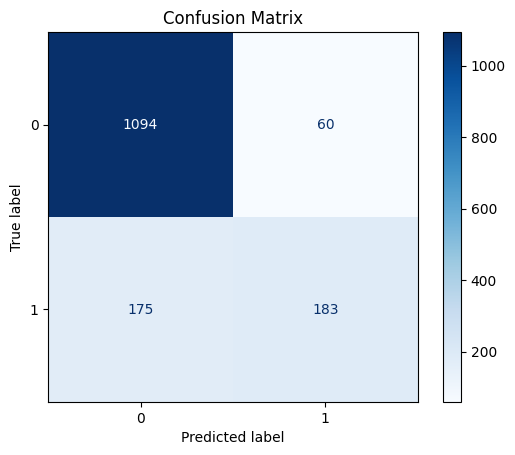

In [25]:
## Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [26]:
## Extract the feature importances
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

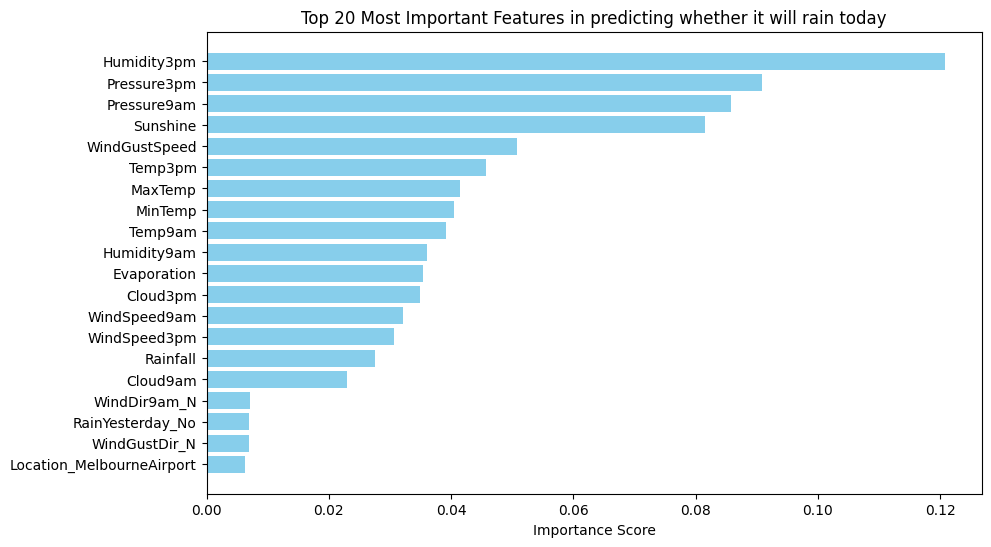

In [27]:
# Combine numeric and categorical feature names
feature_names = numeric_features + list(grid_search.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

N = 20  # Change this number to display more or fewer features
top_features = importance_df.head(N)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {N} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

In [28]:
## Try another model
## Update the pipeline and the parameter grid

pipeline.set_params(classifier=LogisticRegression(random_state=42))

grid_search.estimator = pipeline

param_grid = {
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

grid_search.param_grid = param_grid

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=No

              precision    recall  f1-score   support

          No       0.86      0.93      0.89      1154
         Yes       0.68      0.51      0.58       358

    accuracy                           0.83      1512
   macro avg       0.77      0.72      0.74      1512
weighted avg       0.82      0.83      0.82      1512



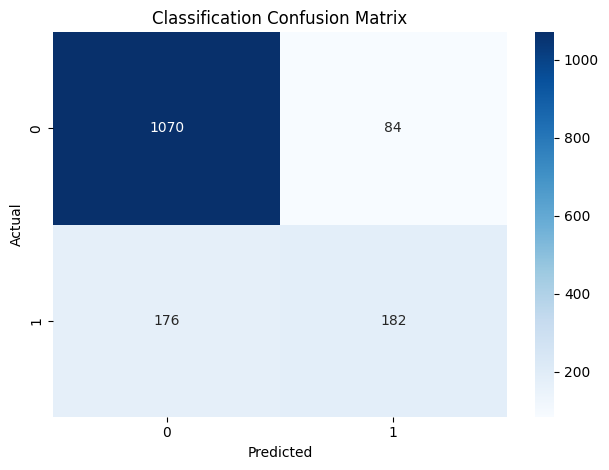

In [29]:
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

plt.title('Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()